**Autor**: Victor Teixidó López

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!pip install apafib --upgrade --user --quiet

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

from sklearn import set_config
import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

# ¿Qué edad tienes?

El conjunto de datos Stroke Prediction Dataset tiene la descripción de un conjunto de personas a partir de características demográficas, médicas y de hábitos. Usualmente, se pueden predecir diferentes cosas a partir de un conjunto de datos y en este caso vamos a intentar predecir la edad de las personas a partir de sus características.

In [3]:
from apafib import load_stroke

stroke_data = load_stroke()
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1,33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
2,14248,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,62602,Female,49.0,0,0,Yes,Private,Urban,60.91,29.9,never smoked,1
4,36338,Female,39.0,1,0,Yes,Private,Rural,58.09,39.2,smokes,1


## Apartado a

Vamos a hacer una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Dividimos el conjunto de datos en entrenamiento y test (70 %/30 %). Después eliminamos las variables que no tiene sentido usar en nuestro problema y transformamos las variables adecuadamente para poder ajustar un modelo de regresión, tanto el conjunto de entrenamiento como el de test.

In [4]:
stroke_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2818.0,NaN,NaN,NaN,36927.369,20893.521,77.0,18716.5,37200.5,54905.75,72940.0
gender,2818,2,Female,1682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,2818.0,NaN,NaN,NaN,26.817,14.429,0.08,15.0,28.0,39.75,49.0
hypertension,2818.0,NaN,NaN,NaN,0.027,0.162,0.0,0.0,0.0,0.0,1.0
heart_disease,2818.0,NaN,NaN,NaN,0.004,0.065,0.0,0.0,0.0,0.0,1.0
ever_married,2818,2,No,1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,2818,5,Private,1634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,2818,2,Urban,1414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,2818.0,NaN,NaN,NaN,96.371,32.064,55.12,75.675,89.195,108.08,267.76
bmi,2818.0,NaN,NaN,NaN,27.589,8.432,10.3,21.5,26.2,32.1,97.6


### Visualización de los datos

Primero de todos vamos a visualizar el comportamiento de los datos tanto individualmente como relacionados con la variable objetivo, para ver si encontramos patrones o características destacables.

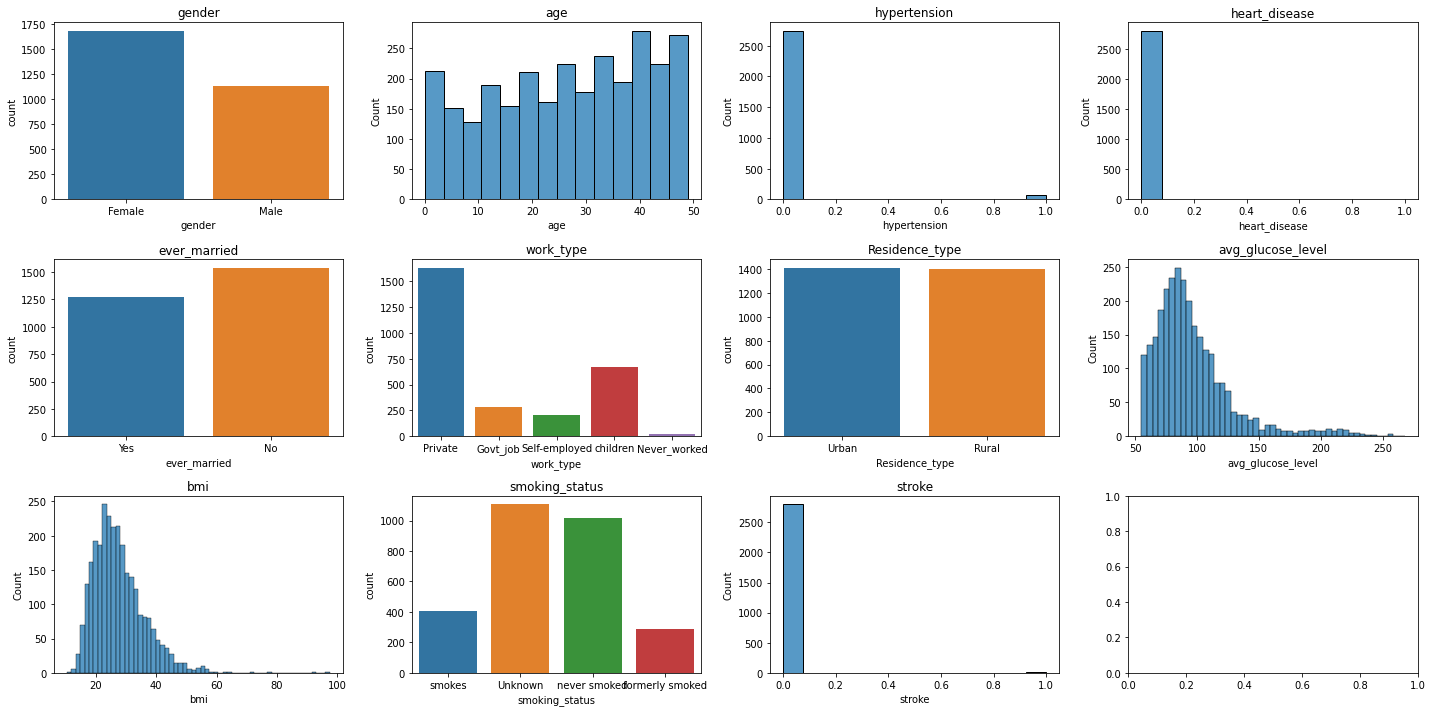

In [5]:
fig, axes = plt.subplots(3,4,figsize=(20,10))

# id variable has no meaning
for i, c in enumerate(stroke_data.columns[1:]):
    ax = axes.reshape(-1)[i]
    if stroke_data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=stroke_data,ax=ax)
    else:
        b = sns.histplot(x=c,data=stroke_data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

#### Variables númericas

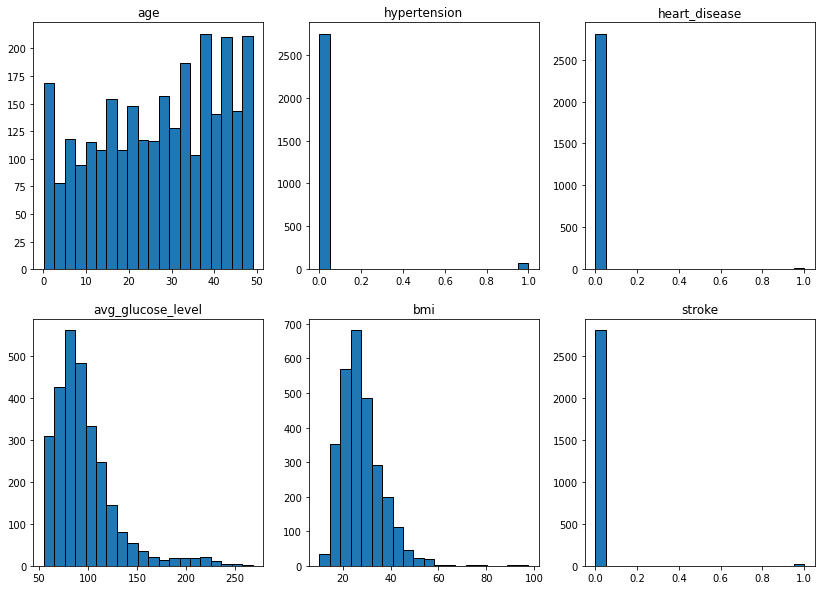

In [6]:
fig,ax = plt.subplots(2,3,figsize=(14,10))

ax[0][0].hist(stroke_data['age'], bins=20, edgecolor='black');
ax[0][0].set_title('age');
ax[0][1].hist(stroke_data['hypertension'], bins=20, edgecolor='black');
ax[0][1].set_title('hypertension');
ax[0][2].hist(stroke_data['heart_disease'], bins=20, edgecolor='black');
ax[0][2].set_title('heart_disease');

ax[1][0].hist(stroke_data['avg_glucose_level'], bins=20, edgecolor='black');
ax[1][0].set_title('avg_glucose_level');
ax[1][1].hist(stroke_data['bmi'], bins=20, edgecolor='black');
ax[1][1].set_title('bmi');
ax[1][2].hist(stroke_data['stroke'], bins=20, edgecolor='black');
ax[1][2].set_title('stroke');

Podemos ver como las variables *hypertension*, *heart_disease* y *stroke*, son en verdad variables binarias y no continuas. Debido a las proporciones que hay, no nos darán ningún tipo de información útil durante la regresión que aplicaremos. Estas 3 variables las eliminaremos de nuestro datos durante el preprocessing.

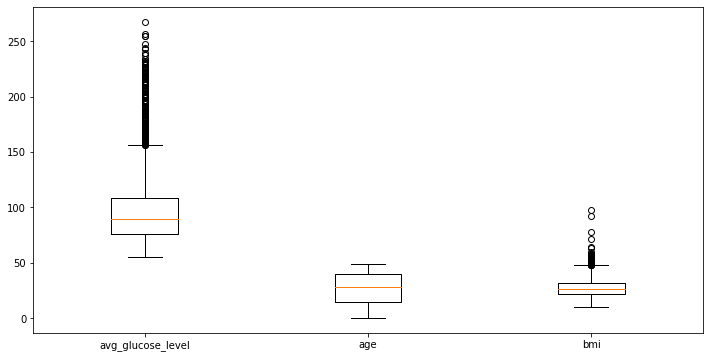

In [7]:
fig,ax = plt.subplots(figsize=(12,6))

boxplot_data = [stroke_data['avg_glucose_level'],stroke_data['age'],stroke_data['bmi']]
ax.boxplot(boxplot_data, labels=['avg_glucose_level','age','bmi']);

Podemos apreciar la existencia de algunos outliers en dos de las variables. A priori, vamos a dejar estos valores por si son de utilidad a la hora de proporcionar información adicional para el correcto ajuste del modelo de regresión.

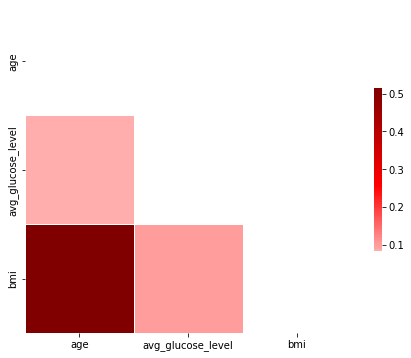

In [8]:
numerical_columns = ['age','avg_glucose_level','bmi']

corr = stroke_data[numerical_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(8,6))
sns.heatmap(corr, mask=mask, cmap='seismic', center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5});

El atributo *bmi* parece tener una correlación bastante elevada con la variable objetivo.

#### Variables categóricas

Female    1682
Male      1136
Name: gender, dtype: int64


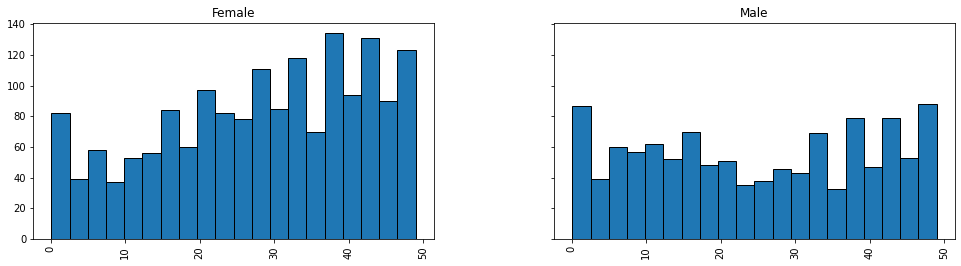

In [9]:
print(stroke_data['gender'].value_counts())

stroke_data.hist(column='age',by='gender',bins=20, sharey=True, figsize=(16,4), layout=(1,2), edgecolor='black');

Podemos afirmar que el número de mujeres entre la gente mayor es más grande que el número de hombres. De cara al ajuste de un modelo de regresión, convertiremos esta variable en una númerica binaria.

No     1542
Yes    1276
Name: ever_married, dtype: int64


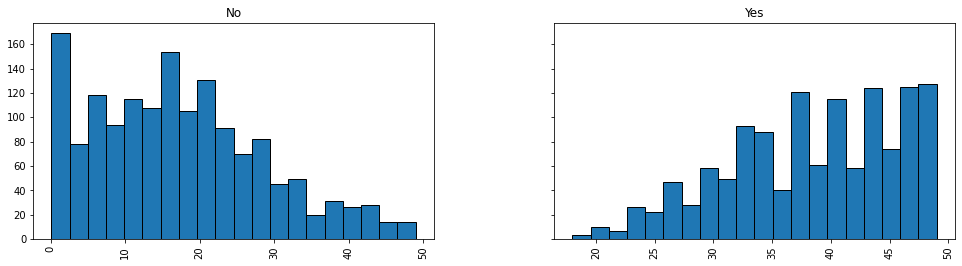

In [10]:
print(stroke_data['ever_married'].value_counts())

stroke_data.hist(column='age',by='ever_married',bins=20, sharey=True, figsize=(16,4), layout=(1,2), edgecolor='black');

Como parece lógico, entre la gente joven hay mucha más gente que nunca ha estado casada. De cara al ajuste de un modelo de regresión, recodificaremos esta variable como una númerica binaria.

Private          1634
children          671
Govt_job          286
Self-employed     205
Never_worked       22
Name: work_type, dtype: int64


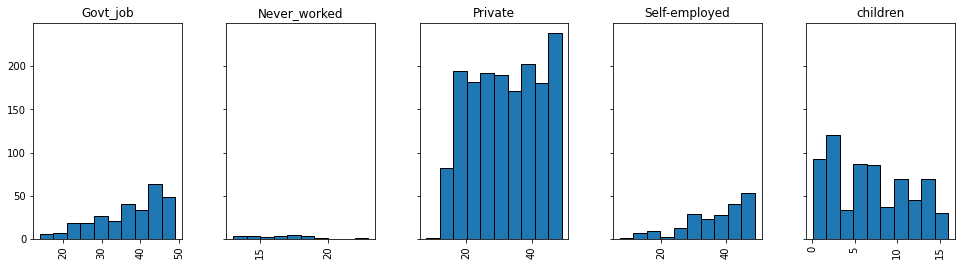

In [11]:
print(stroke_data['work_type'].value_counts())

stroke_data.hist(column='age',by='work_type',bins=10, sharey=True, figsize=(16,4), layout=(1,5), edgecolor='black');

De estas gráficas podemos extraer que entre la gente de mayor edad hay más individuos que trabajan en puesto gubernamentales o que son autónomos. Por otro lado, la gente que nunca ha trabajado o que cuida de niños suelen ser los individuos más jóvenes. De cara al ajuste de un modelo de regresión, convertiremos esta variable en una númerica a través de one-hot encoding, ya que no existe ningún tipo de orden o prevalencia entre las diferentes clases.

Urban    1414
Rural    1404
Name: Residence_type, dtype: int64


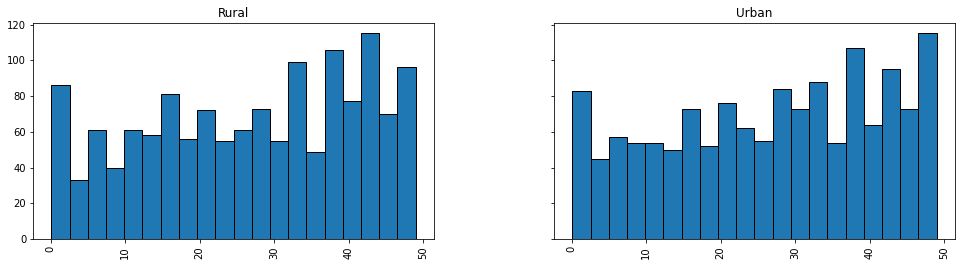

In [12]:
print(stroke_data['Residence_type'].value_counts())

stroke_data.hist(column='age',by='Residence_type',bins=20, sharey=True, figsize=(16,4), layout=(1,2), edgecolor='black');

La residencia entre las distintas edades parece estar distribuida de forma más o menos equitativa. De cara al ajuste de un modelo de regresión, convertiremos esta variable en una númerica binaria para poder utilizarla en el modelo.

Unknown            1107
never smoked       1019
smokes              405
formerly smoked     287
Name: smoking_status, dtype: int64


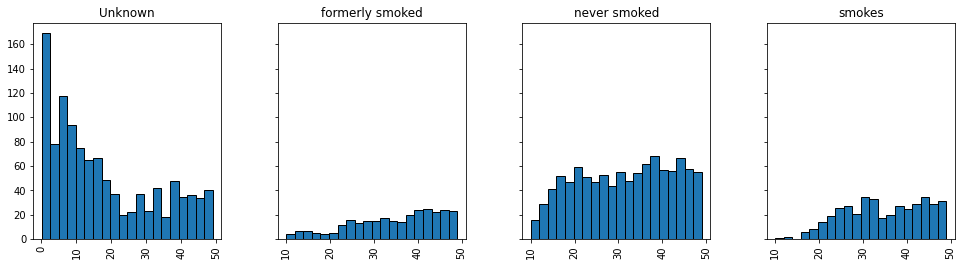

In [13]:
print(stroke_data['smoking_status'].value_counts())

stroke_data.hist(column='age',by='smoking_status',bins=20, sharey=True, figsize=(16,4), layout=(1,4), edgecolor='black');

Entre la gente más joven parece ser que es más común o que no fumen o que no se sepa si fuman o no, la población más mayor suele ser la fumadora. De cara al ajuste de un modelo de regresión, convertiremos esta variable en una númerica, asignaremos los siguientes valores a cada una de las clases en función de su orden:
- never smoked: 0
- Unknown: 1
- formerly smoked: 2
- smokes: 3

### División de los datos

Dividimos los datos en conjutnos de entrenamiento y test (70%/30%).

In [14]:
from sklearn.model_selection import train_test_split

X = stroke_data.loc[:,stroke_data.columns != 'age']
y = stroke_data['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Preprocessing

En primer lugar, recodificamos las variables categóricas según convenga en cada caso para poder utilizarlas en el modelo de regresión LASSO que vamos a ajustar. Luego además renombramos alguna de las variables para más claredad del conjunto de datos.

Por último, eliminamos las variables *id*, *hypertension*, *heart_disease* y *stroke*, ya que como hemos comentado antes no son lo suficientemente significativas para ser consideradas como útiles dentro de nuestro modelo. Además, también eliminamos la variable *work_type*, sustituida por variables que se generan en el proceso de one-hot encoding.

In [15]:
def preprocessing(X, y):
    print('Tamaño original:{}'.format(X.shape))
    
    # codifying categorical values to be used by our regression model 
    X['gender'].replace(['Female','Male'], [1,0], inplace=True)
    X['ever_married'].replace(['Yes','No'], [1,0], inplace=True)
    X['Residence_type'].replace(['Urban', 'Rural'], [1,0], inplace=True)
    X['smoking_status'].replace(['smokes', 'Unknown', 'never smoked', 'formerly smoked'], [3,1,0,2], inplace=True)
    
    # one-hot encoding work_type variable
    work_dummies = pd.get_dummies(X['work_type'], prefix='work', drop_first=True)
    X = pd.concat([X, work_dummies], axis=1)
    
    # rename some attributes
    X.rename({'Residence_type': 'urban_residence', 'work_Never_worked': 'work_never',
              'work_Private': 'work_private', 'work_Self-employed': 'work_self_emp'}, axis=1, inplace=True)
    
    # remove id, hypertension, heart_disease, work_type and stroke columns
    X.drop(columns=['id','hypertension','heart_disease','work_type','stroke'], inplace=True)
    
    # remove categorical variables
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    X.drop(columns=categorical_columns, inplace=True)
    print('Eliminadas: {}'.format(categorical_columns))
    
    # remove missing values
    X=X.dropna()
    y=y[X.index]
    
    print('Nuevo tamaño:{}'.format(X.shape))
    return X, y

Vamos a aplicar el preprocessing especificado tanto al conjunto de entrenamiento como al conjunto de test.

In [16]:
X_train, y_train = preprocessing(X_train,y_train)
print()
X_test, y_test = preprocessing(X_test,y_test)

Tamaño original:(1972, 11)
Eliminadas: []
Nuevo tamaño:(1972, 10)

Tamaño original:(846, 11)
Eliminadas: []
Nuevo tamaño:(846, 10)


In [17]:
X_train.head()

,gender,ever_married,urban_residence,avg_glucose_level,bmi,smoking_status,work_never,work_private,work_self_emp,work_children
1462,1,0,1,72.00,34.4,0,0,0,1,0
1057,0,0,0,101.99,36.3,0,0,1,0,0
1117,1,0,0,72.52,32.0,1,0,1,0,0
2370,1,1,0,68.01,27.7,0,0,1,0,0
2610,0,0,1,66.11,16.3,1,0,0,0,1


Podemos ver que las variables que hemos mencionado han sido eliminadas del conjunto de datos. Por otro lado han aparecido nuevas variables, las generadas por el one-hot encoding de la variable *work_type*.

El siguiente y último paso para dejar los conjuntos de datos listos para el ajuste de un modelo de regresión es la estandarización de los propios datos.

In [18]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

## Apartado b

Aplicamos PCA (Análisis de Componentes Principales) al conjunto de entrenamiento que hemos obtenido del conjunto de datos inicial. Vamos a analizar la evolución de la varianza en función del número de componentes que utilicemos y visualizaremos el propio PCA en 2D representando la variable objetivo. 

In [19]:
pca = PCA().fit(X_train);

print(pca.explained_variance_ratio_)
print()
print(pca.explained_variance_ratio_.cumsum())

[0.23607513 0.1311873  0.1068059  0.10395792 0.10183706 0.09252469
 0.0914295  0.060887   0.05908675 0.01620875]

[0.23607513 0.36726243 0.47406833 0.57802625 0.6798633  0.772388
 0.8638175  0.9247045  0.98379125 1.        ]


En el primer vector, observamos cuánta nueva varianza aporta cada uno de los distintos componentes. En el segundo, podemos ver la varianza acumulada de utilizar un mayor número de componentes. Vemos como necesitaríamos un total de 7 componentes para poder obtener más del 80% de varianza acumulada, este valor es un estándard comúnmente utilizado.

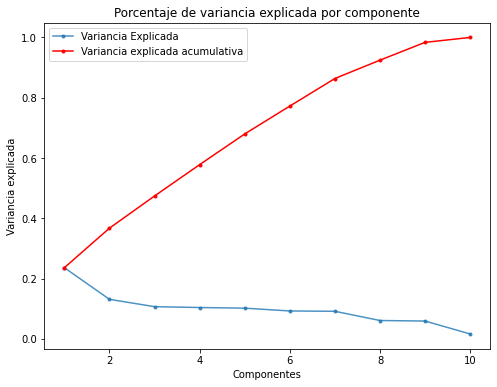

In [20]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_ , alpha=0.8, marker='.',
         label="Variancia Explicada");

y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');

plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red', marker='.',
         label="Variancia explicada acumulativa");

plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

En este gráfico podemos ver de manera ilustrada la evolución tanto de la varianza que aporta cada componente como de la varianza acumulada conseguida a medida que añadimos componentes.

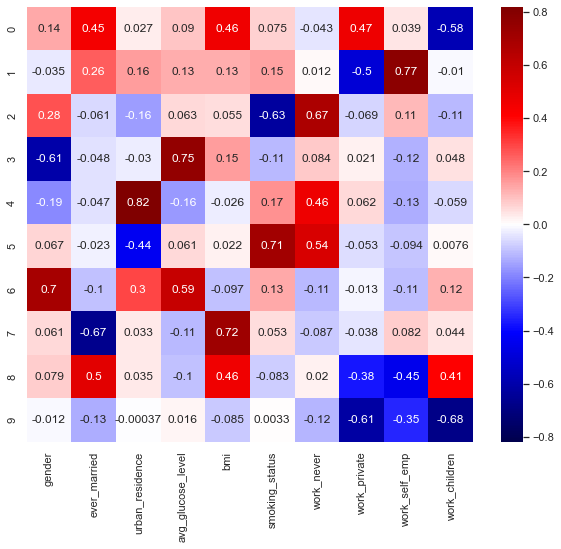

In [21]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(pca.components_, cmap='seismic',
            xticklabels=X_train.columns,
            vmin=-np.max(np.abs(pca.components_)),
            vmax=np.max(np.abs(pca.components_)),
            annot=True);

En esta imagen vemos los pesos que otorga cada una de las componentes a los distintos atributos de nuestro conjunto de datos.

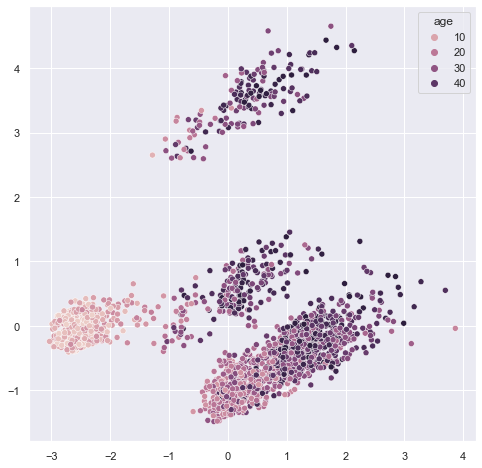

In [22]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

A pesar de necesitar un total de 7 componentes para sobrepasar el lindar del 80% de la varianza acumulada, podemos ver como con únicamente la representación de 2 componentes obtenemos una diferenciación clara de los distintos rangos de edades. Obviamente la representación que obtenemos en este imagen no acaba de ser del todo precisa, esto es debido a que no estamos representando todas las dimensiones que deberíamos.

Podemos confirmar la relación entre la variable objetivo y el resto de variables del conjunto de datos viendo las distintas nubes de puntos que forman los rangos de edades de la variable objetivo.

Vemos una clara nube abajo a la izquierda conformada por el rango de los 10 años. Más en el centro hacía abajo, encontramos una segunda nube algo más oscura que representa las edades de los 20 años.  Algo más a la derecha y arriba, son visibles dos nubes mezcladas que represetan el resto de rangos de edades. Probablemente con más dimensiones, estas distinciones entre los puntos serían más claras.

## Apartado c

Con los datos ya preprocesados y listos, vamos a ajustar un modelo de regresión LASSO para predecir la edad de las personas. Una vez ajustado el modelo, estimaremos la calidad de la regresión. 

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

In [24]:
lasso_cv =LassoCV(alphas=lambdas, cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_)
print('R2 score:',lasso_r2)

Best lambda: 0.01
R2 score: 0.7601948413305265


Vemos que el mejor resultado lo hemos obtenido con una lambda igual a 0.01 y con un valor de R2 de 0.76, aproximadamente.

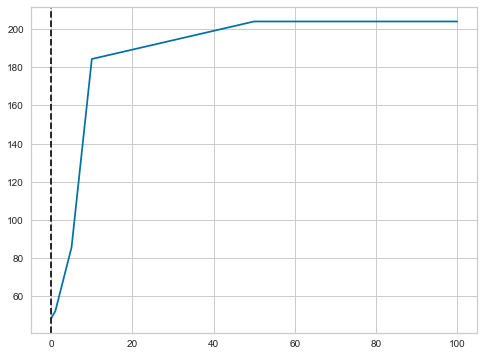

In [25]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

En este gráfico podemos observar la evolución de la selección del parámetro alfa.

In [26]:
r2_results = pd.DataFrame({'lasso_cv':lasso_r2},index=['CV R2'])
r2_results.loc['Train R2', :] =[r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_

r2_results

,lasso_cv
CV R2,0.760
Train R2,0.764
lambda,0.010


Tal y como hemos mencionado antes, podemos ver como hemos obtenido un valor para el conjunto de entrenamiento de aproximadamente 0.764 con una lambda igual a 0.01. A priori no parecen resultados que podrían clasificarse como idóneos, pero tampoco se tratan de resultados malos. Tener un acierto del ~0.764 es un valor aceptable. Si trataramos con temas médicos, como enfermedades, un resultado como este probablemente no sería aceptable. En nuestro caso, donde estamos prediciendo la edad de la gente a raíz de algunos atributos, un valor de acierto de más de 0.75 se podría clasificar de bueno a secas.

In [27]:
weights = pd.DataFrame({'lasso_cv':lasso_cv.coef_},index=X_train.columns)
weights.T

,gender,ever_married,urban_residence,avg_glucose_level,bmi,smoking_status,work_never,work_private,work_self_emp,work_children
lasso_cv,0.047,5.941,0.05,0.347,1.391,0.516,-0.809,-1.504,0.044,-8.237


En esta pequeña tabla vemos los distintos pesos que se le atribuyen a cada uno de los atributos de nuestro conjunto de datos. Podemos ver como los atributos *ever_married* y *bmi* son los que mas infuyen de manera positiva y los atributos *work_private* y *work_children* los que más influyen negativamente.

## Apartado d

Vamos a representar los residuos de la regresión y los valores reales contra las predicciones para el conjunto de test.

In [28]:
y_tes_predicted = lasso_cv.predict(X_test)
r2_ridge = lasso_cv.score(X_test,y_test)

print('Mean squared error with test data: {}'.format(mean_squared_error(y_test,y_tes_predicted)))
print('Mean absolute error with test data: {}'.format(mean_absolute_error(y_test,y_tes_predicted)))
print('R2 score with test data: {}'.format(r2_ridge))

Mean squared error with test data: 46.679861738325
Mean absolute error with test data: 5.496082450696172
R2 score with test data: 0.7861687223175247


Podemos ver ahora que con el conjunto de datos de test, hemos obtenido un acierto de ~0.786 que no está razonablemente bien. El valor del MSE obtenido es de aproximadamente 46.68 (mide el cuadrado de la diferencia entre el valor real y el predicho y es más sensible a outliers). Por otro lado, hemos obtenido un MAE de ~5.496 (mide la distancia media entre el valor real y el predicho).

Tomando por valor las métricas de R2, tal y como decíamos antes, podemos decir que los valores de predicciones correctas que tenemos son aceptables. Además, fijándonos en el MAE, podemos también añadir que el error que solemos obtener no es muy elevado y eso es un buen indicador.

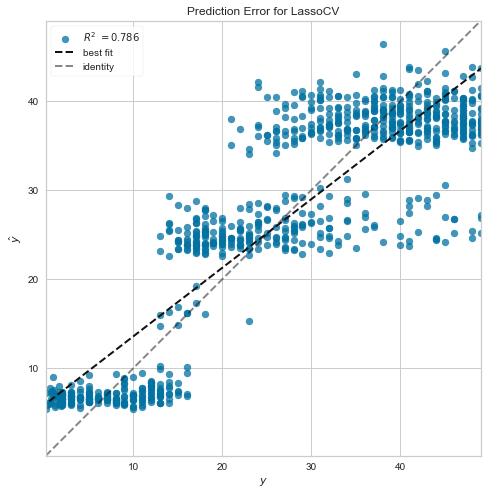

In [29]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8));
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True);

Este gráfico nos muestra los valores reales respecto a los valores predichos por nuestro modelo. Podemos ver distinas secciones o nubes, que corresponden a los distintos rangos de edad que existen en nuestro conjunto de datos. 

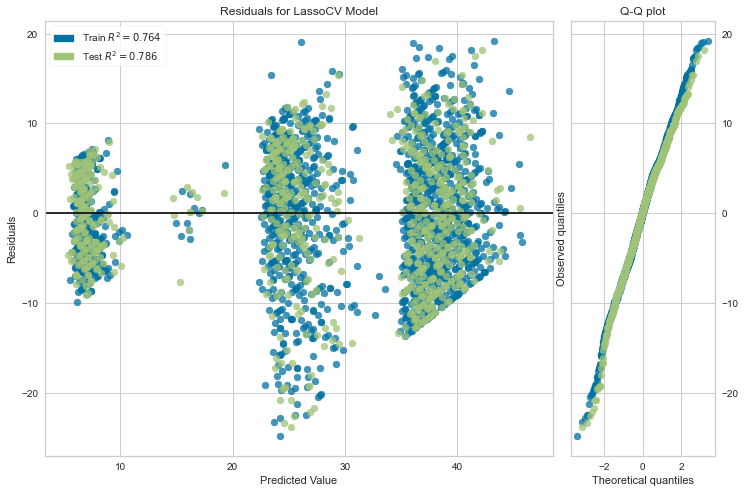

In [30]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

Este gráfico muestra la diferencia entre el valor observado de la variable a predecir y el valor predicho en cuestión. Podemos observar 4 nubes claramente diferenciables, esto se debe a que nuestro modelo más allá de diferenciar individualmente cada año, consigue hacer una generalización entre rangos de edades. Podemos ver que entre la gente joven los residuos son mucho menores, probablemente a que es más facil saber si alguien es joven (por ejemplo no está casado o no tiene hijos). Por otro lado, el rango de los 20-30 años de edad es en el que puede haber valores de residuos más elevados, en estas edades hay diferencias entre las personas (gente ya casada y gente que no, gente con muchos hijos y gente sin, ...). Al igual que pasaba con la gente más joven, la gente mayor es también más fácil de clasificar.